# Getting Started with Kaggle (Model Iteration 1)

In order to learn the basics of kaggle, I start this first model iteration of the Titanic warmup project. Basically, I followed along the tutorial in https://www.dataquest.io/mission/74/getting-started-with-kaggle
and created a simple linear regression and logistic regression to have a simple machine learning model for the survival data in Titanic event.

## Step 1
A good first step is to think logically about the columns and what we're trying to predict. What variables might logically affect the outcome of survived? 

In [28]:
import numpy as np
import pandas as pd
import sklearn

titanic = pd.read_csv("train.csv")
titanic_test = pd.read_csv("test.csv")

Now that we look at the data, and did some exploring of the relationships between variables. We know that women and children were more likely to survive. Thus, Age and Sex are probably good predictors. It's also logical to think that passenger class might affect the outcome, as first class cabins were closer to the deck of the ship. Fare is tied to passenger class, and will probably be highly correlated with it, but might add some additional information. Number of siblings and parents/children will probably be correlated with survival one way or the other, as either there are more people to help you, or more people to think about and try to save.

## Descriptor
A good second step is to look at high level descriptors of the data. In this case, we can use the pandas .describe() method to look at different characteristics of each numeric column.

In [29]:
def Describe(df):
    """
    Prints out abstract description for all variables in a data frame
    """
    # Print the first 5 rows of the dataframe.
    print(df.head(5))
    print(df.describe())

Describe(titanic)


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
       P

## Missing Value
As we can see from the result of describe(), when you used .describe() on the titanic dataframe in the last screen, you might have noticed that the Age column has a count of 714 when all the other columns have a count of 891. This indicates that there are missing values in the Age column -- the count is of non-missing (null, NA, or not a number) values. The data isn't perfect, we need to clean the data ourselves. Here, we will place the Nan in age column with the median of age

In [30]:
# The titanic variable is available here.
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

## Data cleaning
Several of our columns are non-numeric, which is a problem when it comes time to make predictions -- we can't feed non-numeric columns into a machine learning algorithm and expect it to make sense of them.

We will transform sex to 0 for male and 1 for female; change Embarked column from "S", "C", "Q" to 0, 1, 2

In [31]:
# Find all the unique genders -- the column appears to contain only male and female.
print(titanic["Sex"].unique())

# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


In [32]:
# Find all the unique values for "Embarked".
print(titanic["Embarked"].unique())

titanic["Embarked"] = titanic["Embarked"].fillna("S")

titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


## Cross validation
We can now use linear regression to make predictions on our training set. In order to avoid overfitting, I will use cross validation. To cross validate, you split your data into some number of parts. This way, we generate predictions for the whole dataset without ever evaluating accuracy on the same data we train our model using.

## Making predictions
We can use the excellent scikit-learn library to make predictions. We'll use a helper from sklearn to split the data up into cross validation folds, and then train an algorithm for each fold, and make predictions. At the end, we'll have a list of predictions, with each list item containing predictions for the corresponding fold.

In [33]:
# Import the linear regression class
from sklearn.linear_model import LinearRegression
# Sklearn also has a helper that makes it easy to do cross validation
from sklearn.cross_validation import KFold

# The columns we'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm class
alg = LinearRegression()
# Generate cross validation folds for the titanic dataset.  It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # The predictors we're using the train the algorithm.  Note how we only take the rows in the train folds.
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = titanic["Survived"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)

## Evaluating error
Now that we have predictions, we can evaluate our error.

We'll first need to define an error metric, so we can figure out how accurate our model is. From the Kaggle competition description, the error metric is percentage of correct predictions. We'll use this same metric to evaluate our performance locally.

Specifically, I will figure out what proportion of the values in predictions are the exact same as the values in titanic["Survived"]. This calculation should be left as a float (decimal) and assigned to the variable accuracy.

In [34]:
import numpy as np

# The predictions are in three separate numpy arrays.  Concatenate them into one.  
# We concatenate them on axis 0, as they only have one axis.
predictions = np.concatenate(predictions, axis=0)

# Map predictions to outcomes (only possible outcomes are 1 and 0)
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0

accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print "Accuracy: ", accuracy

Accuracy:  0.783389450056


/home/yuzhong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


## Logistic regression
In the next phase, we will try logistic regression to make a prediction. Sklearn has a class for logistic regression that we can use. We'll also make things easier by using an sklearn helper function to do all of our cross validation and evaluation for us.

In [35]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

# Initialize our algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score for all the cross validation folds.  (much simpler than what we did before!)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.787878787879


## Processing the test data
We'll also need to replace a missing value in the Fare column. Use .fillna with the median of the column in the test set to replace this. There are no missing values in the Fare column of the training set, but test sets can sometimes be different.

In [36]:
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

## Make the first Submission
Create a new dataframe with only the columns Kaggle wants from the dataset.


In [37]:
# Initialize the algorithm class
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

# submission.to_csv("titanic_submission.csv", index=False)

## Result

After submitting the file, I get an accuracy of 0.75120

## Revisions

As we can see the score is not very high, which means the model still can be improved greatly. In the model iteration 1, I will add two revision to the model to make it more accruate in predicting.



### Adding new feature of ThirdClassMale

The rationale behind that revision is that third class males has a very low rate of survival (about 13%). Seperating this attribute may increase the accuracy of the model

In [38]:
# Find all the unique values for "Pclass".
titanic["ThirdClassMale"] = 0

conditions = (titanic["Pclass"] == 3) & (titanic["Sex"] == 0)
titanic.loc[conditions, "ThirdClassMale"] = 1

Same change for the test data

In [39]:
# Find all the unique values for "Pclass".
titanic_test["ThirdClassMale"] = 0

conditions = (titanic_test["Pclass"] == 3) & (titanic_test["Sex"] == 0)
titanic_test.loc[conditions, "ThirdClassMale"] = 1

### Adding a new feature of UpperClassFemale
From my data exploration, I figured out that women from pClass 1 and 2 has above 90% survival rate. By seperating that fact into a new feature, I hope to make my model more accurate when predicting upper class females.

In [40]:
# Find all the unique values for "Pclass".
titanic["UpperClassFemale"] = 0

conditions = (titanic["Pclass"] == 1) | (titanic["Pclass"] == 2) & (titanic["Sex"] == 1)
titanic.loc[conditions, "UpperClassFemale"] = 1

Do the same change for test data

In [41]:
# Find all the unique values for "Pclass".
titanic_test["UpperClassFemale"] = 0

conditions = (titanic_test["Pclass"] == 1) | (titanic_test["Pclass"] == 2) & (titanic_test["Sex"] == 1)
titanic_test.loc[conditions, "UpperClassFemale"] = 1

Update the predictors

In [42]:
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'UpperClassFemale', 'ThirdClassMale']

## Implementing a random forest

Make cross validated predictions for the titanic dataframe (which has already been loaded in). Use 3 folds. Use the random forest algorithm stored in alg to do the cross validation. Use the predictors to predict the Survived column. Assign the result to scores

In [43]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.814814814815


## Parameters Tuning
The score in train dataset is increased significantly. However, when I tried to submit that model to Kaggle, score drops by 2 to 3 percent. The reason is overfitting and indeed, overfitting is a major problem in random forest model. Thing we can do to improve the accuracy of the random forest is to increase the number of trees we're using. Training more trees will take more time, but because of the fact that we're averaging many predictions made on different subsets of the data, having more trees will increase accuracy greatly (up to a point).

The first thing I will try is to tune the parameters "min_samples_split" and "min_samples_leaf". Increasing the value of these parameters will reduce overfitting

In [44]:
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=2)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.821548821549


As we can see, reducing overfitting increase the score in cross section, but the score for test data is still relatively low for Kaggle.

## Generating new features
Here I will combine SibSp and Parch to a new feature ""FamilySize"

In [45]:
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

Update the predictors and do a test

In [46]:
predictors = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked', 'UpperClassFemale', 'ThirdClassMale']

In [47]:
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=2)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.821548821549


That's very interesting, it seems that combining two variables won't affect the random forcast algorithm at all.

Then, I extract the title of the passenger from their name. The titles take the form of Master., Mr., Mrs.. There are a few very commonly used titles, and a "long tail" of one-off titles that only one or two passengers have.

We'll first extract the titles with a regular expression, and then map each unique title to an integer value.

We'll then have a numeric column that corresponds to the appropriate Title.

In [48]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
titles_test = titanic_test["Name"].apply(get_title)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v
    titles_test[titles_test == k] = v

# Add in the title column.
titanic["Title"] = titles
titanic_test["Title"] = titles_test
titanic_test.loc[titanic_test["Title"] == 'Dona', "Title"] = 2

# Update the predictors
predictors = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked', 'UpperClassFemale', 'ThirdClassMale', 'Title']

## Finding the best features
To evaluate features, I will use univariate feature selection. This essentially goes column by column, and figures out which columns correlate most closely with what we're trying to predict 

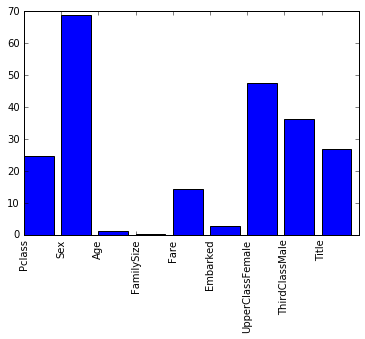

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

## Ensembling

In this case, we'll ensemble logistic regression trained on the most linear predictors (the ones that have a linear ordering, and some correlation to Survived), and a gradient boosted tree trained on all of the predictors

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# Update the predictors
predictors = ['Pclass', 'Sex', 'Fare', 'UpperClassFemale', 'ThirdClassMale', 'Title']

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), predictors]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.806958473625


/home/yuzhong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [51]:
from sklearn.neural_network import BernoulliRBM

alg_test = BernoulliRBM(n_components=256, learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, random_state=1)

In [52]:
# full_predictions = []
# for alg, predictors in algorithms:
#     # Fit the algorithm using the full training data.
#     alg.fit(titanic[predictors], titanic["Survived"])
#     # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
#     predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
#     full_predictions.append(predictions)

# # The gradient boosting classifier generates better predictions, so we weight it higher.
# predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

# # Create a new dataframe with only the columns Kaggle wants from the dataset.
# predictions[predictions <= .5] = 0
# predictions[predictions > .5] = 1
# predictions = predictions.astype(int)

# Update the predictors
predictors = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Fare', 'Embarked', 'UpperClassFemale', 'ThirdClassMale', 'Title']

# Train the algorithm using all the training data
alg_test.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("titanic_submission.csv", index=False)

ValueError: X has 9 features per sample; expecting 6

## Result and Next Step

After I upload my revised submission. I get a score of 0.78033, which is improved by 2.5%.

My model still need a lots of improvement, including changing the number in age, since obviously, age for survival is absolutely not linear. There is a interesting right-skewed distribution, I might want to apply this model to my data. Also, I will try seperating women and men group. Treat them as different set of datas can machine learning them separately